# Introduction

This notebook allows you to apply a simplified version of the ANTARESS workflow to a dataset obtained during an exoplanet transit, for one of the following purposes:
- format, clean, and detrend time-series of echelle spectra (S2D fit files) output by ESPRESSO-like DRS. The default version is set up to process a real dataset, obtained with ESPRESSO during the transit of TOI-421c, but settings can be adjusted to process your own dataset. At the end of the notebook, spectra are still in echelle format on their original spectral grid (defined in the solar barycentric rest frame), have comparable low-frequency spectral profiles, and are corrected for various instrumental, environmental, and stellar effects. 
- format and detrend time-series of CCFs fit files, for preliminary analysis. It is advised to compute CCFs self-consistently with ANTARESS from S2D.

Whatever the use of this notebook, set `working_path`, `star_name`, and `pl_name` to the same values that you used in the [set-up notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) to initialize your system and dataset. Once reduced, your dataset can be [processed](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/DI_analysis_nbook_setup.ipynb) for further analyses.

To exploit the workflow to its full capabilities (e.g., to process multiple planets and datasets), run its executable with the [configuration files](https://obswww.unige.ch/~bourriev/antaress/doc/html/installation.html).

In [1]:
import ANTARESS_nbook_bground
input_nbook = {
    'working_path' : '/Users/bourrier/Travaux/ANTARESS/Working_dir/',
    'star_name' : 'TOI421',
    'pl_name'   : 'TOI421c'
}
input_nbook = ANTARESS_nbook_bground.load_nbook(input_nbook, 'Reduc')

# General

**Modules**

The workflow runs each module successively. Outputs of a given module are stored on disk and used as inputs by subsequent modules. 
The `calc_X` field sets a given module to *calculation* or *retrieval* mode, so that it either processes data (which can take some time with large datasets) or retrieves already processed data. This allows you to run a module (i.e., run its cell to initialize it and then [run the workflow](#Launch_ANTARESS)), to check ANTARESS log and [plots](#Plot_display) to adjust the module settings, and once satisfied to set the module to *retrieval* mode before moving on to the next module.

If you change a module settings, do not forget to run the workflow again after setting this module and all modules depending on its outputs to *calculation* mode.

**Plots**

ANTARESS plots require intermediate data products that are only saved if the plots have been requested when running the workflow. 
If you want to generate the plots of a given module you thus need to run this module's cell in *calculation* mode, and the plot's cell, before running the workflow.
If you then change the plot options you just need to run the module's cell in *retrieval* mode, and the plot's cell, before running the workflow.

Most plots are specific to a given module. When processing S2D you can however use the `flux_sp` and `trans_sp` fields to compare the flux spectra and transmission spectra, respectively, output by two different modules. This allows assessing directly the impact of a given correction. The following options are available:
- `iord2plot` (list, int) : indexes of spectral orders to be plotted. If several orders are requested they will overplotted together.
- `x_range` (list, float) : start and end wavelengths to be plotted (in A). Must overlap with the ranges covered by the selected spectral orders. Set to `None` for automatic determination.
- `y_range_X` (list, float) : vertical range of the plot, in absolute or relative flux units. Set to `None` for automatic determination.
- `pre` (str) and `post`(str) : steps from which to plot the outputs. Choose among `raw` (input data), `tell` (after telluric correction), `fbal` (after flux balance correction), `cosm` (after cosmics correction), `wig` (after wiggle correction).
- `plot_err` (bool): plot errors associated with profile
- `bin_width` (float): overplots binned transmission spectra at the requested resolution (set to 0 to prevent)
- `gap_exp` (float): vertical offset between transmission spectra, for better visibility

A single occurrence of these plots is generated for a given run of the workflow. Depending on which module outputs you requests, you will need to run the workflow again with the relevant modules and their dependencies set to *calculation* mode.

In [2]:
# Plot selection
input_nbook['sp_reduc']['flux_sp']  = True 
input_nbook['sp_reduc']['trans_sp'] = True

# Common options
input_nbook['sp_reduc'].update({
    'iord2plot'     : [113,115,117],
    'x_range'       : None, #[5750.,5770.], 
    'pre'           : 'raw',
    'post'          : 'tell',
    'plot_err'      : False,
    'bin_width'     : 2.
})

# Flux spectra
input_nbook['sp_reduc'].update({
    'y_range_flux'  : None,
})

# Transmission spectra
input_nbook['sp_reduc'].update({
    'y_range_trans' : None,
    'bin_width'     : 2.,
    'gap_exp'       : 0.
})

ANTARESS_nbook_bground.plot_spec(input_nbook)

# Data upload and formatting

Run this cell to initialize the module tasked to upload the dataset and to put in ANTARESS format. 

When processing S2D you have the possibility to permanently mask parts of the dataset for the entire workflow process, by filling in the following fields:
- 'iexp2keep' (list, int) : indexes of exposures to be kept, e.g., `list(np.delete(np.arange(54),[0,53])`
- `iord2del` (list, int): indexes of spectral orders to be removed, e.g., [10,24]
- `wav2mask` : list of wavelength ranges to be masked in a selection of spectral orders, e.g. {10:$[[\lambda_{\mathrm{low}, 1}, \lambda_{\mathrm{high}, 1}], [\lambda_{\mathrm{low}, 2}, \lambda_{\mathrm{high}, 2}]]$} would mask those two ranges in order 10. Indexes are relative to the order list screened by `iord2del`. Here, all exposures are masked (finer control is available using the full workflow).

Which parts of a dataset to exclude is determined iteratively as you run the modules and analyze their outputs. In the present example, the overall quality of all exposures and spectral orders is sufficient that none has to be excluded, and we mask localized spectral ranges affected by emission peaks and poorly corrected deep telluric lines. Consecutive spectral orders are masked because they are duplicated in ESPRESSO data.

In [3]:
#Masking
input_nbook['sp_reduc'].update({
    'iexp2keep': [],
    'iord2del' : [],
    'wav2mask' : {130:[[6300.42,6300.68]],131:[[6300.42,6300.68]],        
                  132:[[6364,6364.15]],133:[[6364,6364.15]],                        
                  146:[[6865.,6930.]],147:[[6865.,6930.]],
                  148:[[6900,6940]],149:[[6900,6940]],
                  162:[[7590,7615]],163:[[7590,7615]],
                  164:[[7595.,7698.]],165:[[7595.,7698.]],
                  166:[[7690,7705]],167:[[7690,7705]]},
})

# Calculate/retrieve
input_nbook['sp_reduc']['calc_proc_data'] = True & False

ANTARESS_nbook_bground.processing_mode(input_nbook)

# Spectral corrections

The following cells are only relevant when processing S2D.

<a id='inst_cal'></a>
**Instrumental calibration**

Input spectra from the DRS are assumed to be corrected for standard instrumental effects, in particular the blaze from the spectrograph grating.
Run this cell to retrieve the blaze and detector noise profiles, which will be used throughout the workflow to scale back temporarily spectra from flux density to blazed count units, and to perform accurate weighted means.

For these operations to be accurate, you need to provide the `S2D_BLAZE_A.fits` files of your dataset in the same directory as the input data.

In [4]:
# Calculate/retrieve
input_nbook['sp_reduc']['calc_gcal'] = True  & False

ANTARESS_nbook_bground.inst_cal(input_nbook)

Run the cell below to plot the retrieved calibration and detector noise profiles.

Define the indexes of spectrograph order and exposure to be plotted.

In [5]:
input_nbook['sp_reduc']['iord2plot_gcal'] = 113
input_nbook['sp_reduc']['iexp2plot_gcal'] = 5

ANTARESS_nbook_bground.inst_cal_plot(input_nbook)

Plots are stored in the `/Working_dir/Star/Planet_Plots/General/gcal/` directory.

**Telluric correction**

Run this cell to correct spectra for telluric absorption lines. You can adjust: 
- `tell_species` (list, string): telluric molecules to considered (H$_2$O, O$_2$, CH$_4$, CO, CO$_2$)       
- `tell_thresh` (float): telluric lines with contrast deeper than this threshold (0 = no absorption, 1 = full absorption) are masked

In [6]:
input_nbook['sp_reduc'].update({
    'tell_species'     : ['H2O', 'O2'],
    'tell_thresh'      : 0.9
})

# Calculate/retrieve
input_nbook['sp_reduc']['calc_tell'] = True & False

ANTARESS_nbook_bground.tell_corr(input_nbook)

Run the cell below to plot:
- the telluric CCFs from the model, and from the raw and corrected data.
- the properties of the best-fit telluric model

In [7]:
ANTARESS_nbook_bground.tell_corr_plot(input_nbook)

Plots are stored in the `/Working_dir/Star/Planet_Plots/Spec_raw/Tell_corr/Instrument_Visit/Tell_CCF/` and `/Working_dir/Star/Planet_Plots/Spec_raw/Tell_corr/Instrument_Visit/Tell_prop/` directories.

**Flux balance correction**

Run this cell to correct spectra for low-frequency flux variations induced by Earth atmosphere. 
The spectral flux balance is reset to that of the median spectrum over all exposures in the visit, using a 1D-smoothing spline fitted to the ratio between each exposure spectrum and the reference:
- `iord2excl` (list): indexes of spectral orders to be excluded from the fit (indexes can be read on the top axis of the plot below).
- `smooth_fac` (float): spline smoothing factor. Increase to smooth. 

We advise running this module iteratively, starting with a low smoothing factor and using the plots, to identify the orders to exclude and adjust the smoothing. The spline must capture low and medium-frequency variations without overfitting high-frequency variations. In the present example we excluded noisy orders in the bluest part of the spectrum, at the interface between ESPRESSO blue and red detectors, and too strongly contaminated by tellurics in the red part of the spectrum. The smoothing factor allows capturing the medium-frequency variation around 5750 A. 

In [8]:
input_nbook['sp_reduc'].update({
    'iord2excl'  : [0,1,88,89,90,91,145,146,147,164,165],
    'smooth_fac'    : 1.5e-5
})

# Calculate/retrieve
input_nbook['sp_reduc']['calc_Fbal'] = True & False

ANTARESS_nbook_bground.fbal_corr(input_nbook)

Run the cell below to plot the measured and fitted flux balance variations.
Variations can be better visualized by offsetting each exposure spectrum with `gap_exp`.

In [9]:
input_nbook['sp_reduc']['gap_exp'] = 0.

ANTARESS_nbook_bground.fbal_corr_plot(input_nbook)

Plots are stored in the `/Working_dir/Star/Planet_Plots/Spec_raw/FluxBalance/Instrument_Visit/` directory.

**Cosmics correction**

Run this cell to correct for cosmic rays. Pixels in a given exposure are flagged and replaced if their flux deviates from the mean over adjacent spectra by more than the pixel error, and than the standard deviation over these adjacent spectra, times a threshold. You can adjust:
- `align` (str)   : align spectra for comparison using the Keplerian model defined by your input system properties (`kep`) or the DRS radial velocities (`rv`). The former option is preferred to avoid biases due to strong Rossiter-McLaughlin anomalies, but requires an accurate model.     
- `ncomp` (int)   : total number of adjacent spectra.  
- `thresh` (float): threshold for cosmic rays detection.


In [10]:
input_nbook['sp_reduc'].update({
    'align' : 'kep',
    'ncomp' : 10,
    'thresh': 10.
})

# Calculate/retrieve
input_nbook['sp_reduc']['calc_cosm'] = True & False

ANTARESS_nbook_bground.cosm_corr(input_nbook)

Run the cell below to plot the flux deviation to error ratios in each exposure and order with flagged cosmics, and the distribution of flagged cosmics.

In [11]:
ANTARESS_nbook_bground.cosm_corr_plot(input_nbook)

Plots are stored in the `/Working_dir/Star/Planet_Plots/Spec_raw/Cosmics/Instrument_Visit/` directory.

**ESPRESSO "wiggles" correction**

This notebook provides a brute-force approach to correct for ESPRESSO interference pattern, using a Savitzky-Golay filter. 
We caution that filtering may overcorrect stellar or planetary variations of interest and that the analytical wiggle model available through the full workflow, although more complex to set up, should be preferred.

First, activate the `screening` field to plot the ratios between each exposure spectrum and the mean spectrum over the visit, and identify  which spectral ranges (defined in units of light frequency $\nu$ = c/$\lambda$) should be used to fit the wiggles. You can set `y_range_scr` to a common range for all exposure plots, or set it to `None` for self-determination. As in the example of TOI-421, you would typically exclude the range at the edges of the blue and red detectors ($\sim$57.5 x $10^{13}$Hz) and the bluest part of the spectra (here $>$ 67.3 x 10$^{13}$Hz) where noise becomes larger than the wiggles.

Indicate the lower and upper boundaries of the spectral ranges to be fitted through the field `fit_range`, defined as [[$\nu_{low,1}$ , $\nu_{high,1}$], [$\nu_{low,2}$ , $\nu_{high,2}$], ...]. 

Then, deactivate the screening and activate the `filter` field to fit and correct for the wiggles. Be careful to choose an appropriate combination of the following parameters to avoid overfitting high-frequency features in the transmission spectra:
- `window` (float): size of the smoothing window (in $\nu$)
- `deg` (int): degree of the polynomial used to fit the smoothed spectrum

In [12]:
#Screening
input_nbook['sp_reduc']['screening'] = True & False
input_nbook['sp_reduc']['y_range_scr'] = None

#Fitted ranges
input_nbook['sp_reduc']['fit_range'] = [[20.,50.6],[51.1,54.2],[54.8,57.1],[57.8,67.3]]

#Filtering
input_nbook['sp_reduc']['filter'] = True #& False
input_nbook['sp_reduc']['window'] = 0.2
input_nbook['sp_reduc']['deg'] = 3

# Calculate/retrieve
input_nbook['sp_reduc']['calc_wig'] = True & False

ANTARESS_nbook_bground.wiggle_corr(input_nbook)

Screening and filtering plots are stored in the `/Working_dir/Star/Planet_Plots/Spec_raw/Wiggles/Exp_fit/Instrument_Visit/Init/` and `/Filter/` directories, and can be visualized in the [plot display](#Plot_display).

# Detrending  

**Skip this step if you have not yet characterized stellar line variations with the [Trends](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/DI_analysis_nbook_setup.ipynb) notebook.**

At this stage, the original dataset has been set in ANTARESS format and (for S2D) cleaned from known instrumental and environmental effects. You can further detrend the stellar lines, following these steps:
- convert the S2D time-series into CCFs using the next module
- use the [Trends](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/DI_analysis_nbook_setup.ipynb) notebook to characterize possible variations
- if relevant, use this detrending module with the results of your analysis
- run the pipeline again
- OPTIONAL: you can check the quality of the detrending by using again the Trends notebook (after recomputing CCFs when reducing S2D).

To set up the detrending, fill-in the fields below with the parameters and coefficients you derived from your trend analysis, using the format `prop_coord : [c_1,c_2,..]`. Many detrending possibilities are available through the full workflow and its configuration file.
Here you can detrend the line contrast (`prop = 'ctrst'`) and rv position (`prop = 'RV'`), as a function of orbital phase (`coord = 'phasePlanetName'`) or S/N (`coord = 'snr'`). The detrending model is a polynomial with coefficients `c_1` (linear), `c_2` (quadratic), etc. Contrast coefficients have no unit; rv coefficients are in km/s. No zeroth-order coefficient is defined because detrending conserves the mean level of the properties over the visit.

The example of the TOI-421c below is typical of trends encountered in transit datasets, with linear drifts in RV over time and variations in line contrast correlated with S/R. 

**Important**
- detrending S2D line FWHM is not possible with ANTARESS
- detrending S2D line contrast requires determining the global flux level of the spectra (using the [processing](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_processing.ipynb) notebook) and the stellar continuum (using the [master spectrum](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_master.ipynb) notebook).

In [13]:
# Detrended properties
input_nbook['sp_reduc']['detrend']={
    'ctrst_snr' : [-1.684704e-05],
    'RV_phaseTOI421c': [-8.113291e-02]}  

# Calculate/retrieve
input_nbook['sp_reduc']['calc_detrend'] = True #& False

ANTARESS_nbook_bground.detrend(input_nbook)

# Converting spectra into CCFs

Run this cell to cross-correlate the S2D spectra with a chosen mask. You need to define:

+ `start_RV` (float): lower boundary of the CCF RV grid (in km/s), relative to the systemic velocity
+ `end_RV` (float): upper boundary of the CCF RV grid (in km/s), relative to the systemic velocity
+ `dRV` (float): step size of the CCF RV grid (in km/s). Set to `None` to use instrumental resolution
+ `mask_path` (string): path (relative to `'working_path'`) + name of the mask file
+ `calc_CCF` (bool): set to `False` to retrieve the CCFs and not calculate them again
  
As an example, we provide the [CCF mask](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ESPRESSO_new_G9.fits) used by the ESPRESSO DRS for G9-type stars. 

In [ ]:
input_nbook['par'].update({
    'start_RV' : -150.,
    'end_RV'   :  150.,
    'dRV'      : None,
    'mask_path': '/ESPRESSO_new_G9.fits',
    'calc_CCF' : True & False,
})
ANTARESS_nbook_bground.conv_CCF(input_nbook,'DI')

Run the next cell to plot CCFs converted from S2D, or provided as input to the notebook.

In [ ]:
ANTARESS_nbook_bground.plot_prof(input_nbook,'DI_prof')

<a id='Launch_ANTARESS'></a>
# Running ANTARESS

Run this cell to run the ANTARESS workflow.

In [14]:
from antaress.ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_launcher(working_path=input_nbook['working_path'], nbook_dic = input_nbook, exec_comm=False)

****************************************
Launching ANTARESS
****************************************

Multi-threading: 16 threads available
Running with observational data
Study of: TOI421c
Accounting for Keplerian motion from all planets
Automatic definition of T14[TOI421c]=2.76 h
Default nsub_Dpl[TOI421c]=26

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing 2D echelle spectra
   > Errors propagated from raw data
   > Data processed on individual spectral tables for each exposure
         Retrieving data
         Processing visit 20231106
           Date (night start) : 2023/11/06
           Visit midpoint: 2460255.75606 BJD
           Exposures do not share a common spectral table
           54 exposures
   > Estimating instrumental calibration
         Retrieving data for 20231106
   > Correcting spectra for tellurics
         Retrieving data for 20231106
   > Calculating stellar masters
         Retrieving data for 20231106

Run the next cell to save the system settings, in case you want to further process your dataset with other notebooks.
In that case you should first run the workflow with all modules set to *retrieval* mode, to avoiding repeating those calculations in other notebooks. 

In [ ]:
ANTARESS_nbook_bground.save_system(input_nbook)

<a id='Plot_display'></a>
# Plot display

In [15]:
from IPython.display import Image,display
from IPython.core.display import HTML 

Run the cells below to show saved plots.

**Flux spectra**

This plot displays the flux spectra over the spectral orders you selected, at the outputs of the `pre` (blue) and `post` (red) steps, respectively.

Choose the index of the exposure you want to plot

In [16]:
iexp2plot = 5

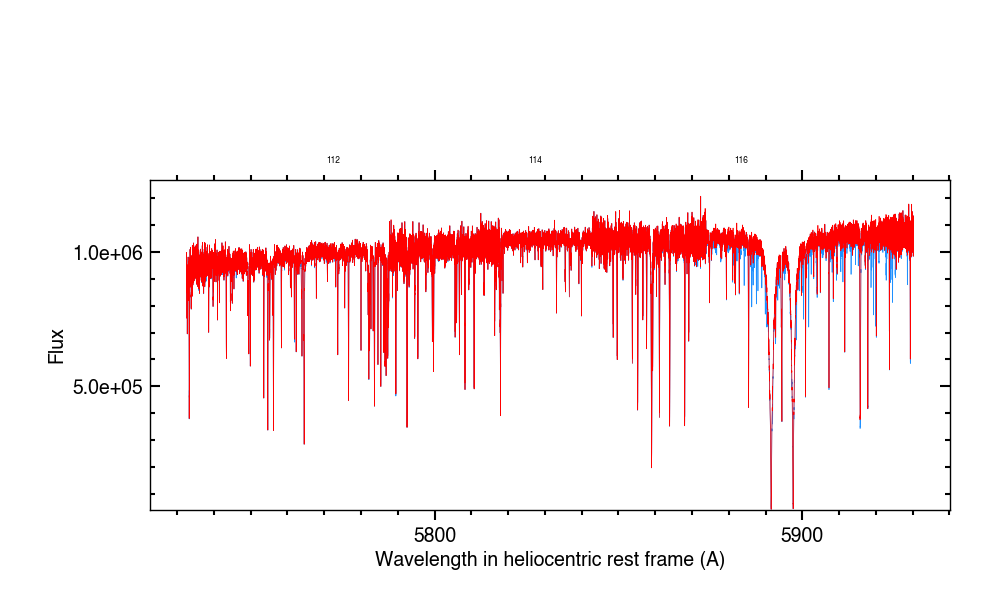

In [17]:
path = ANTARESS_nbook_bground.find_exp(iexp2plot, input_nbook['plot_path']+'DI_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/Spec/')
if path is not None:display(Image(filename = path))

**Transmission spectra**

This plot displays the transmission spectra over the spectral orders you selected, at the outputs of the `pre` (blue) and `post` (red) steps, respectively. If requested, binned spectra are plotted in green (`pre`) and orange (`post`).

Choose the index of the exposure you want to plot

In [18]:
iexp2plot = 5

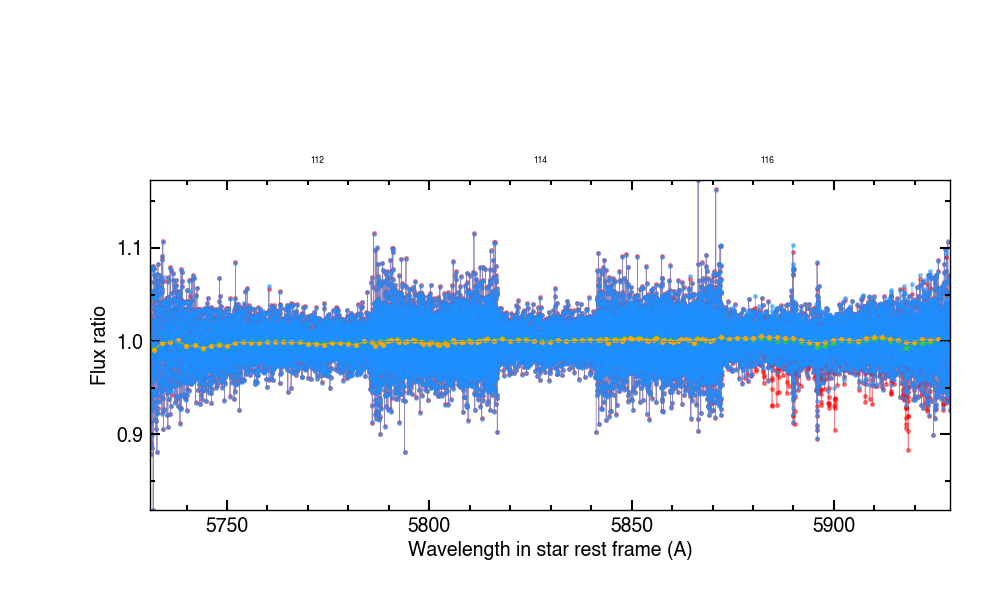

In [19]:
path = ANTARESS_nbook_bground.find_exp(iexp2plot, input_nbook['plot_path']+'Spec_raw/DI_trans/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/')
if path is not None:display(Image(filename = path))

**Instrumental calibration profiles**

This plot displays the measured instrumental calibration profiles from your chosen exposure and spectral order. They are used to define spectral weighing profiles.
Vertical lines indicate the transitions between the piecewise polynomial functions making up the model fitted to the measured profiles over all exposures. This common model is used for the flux-to-counts scaling.

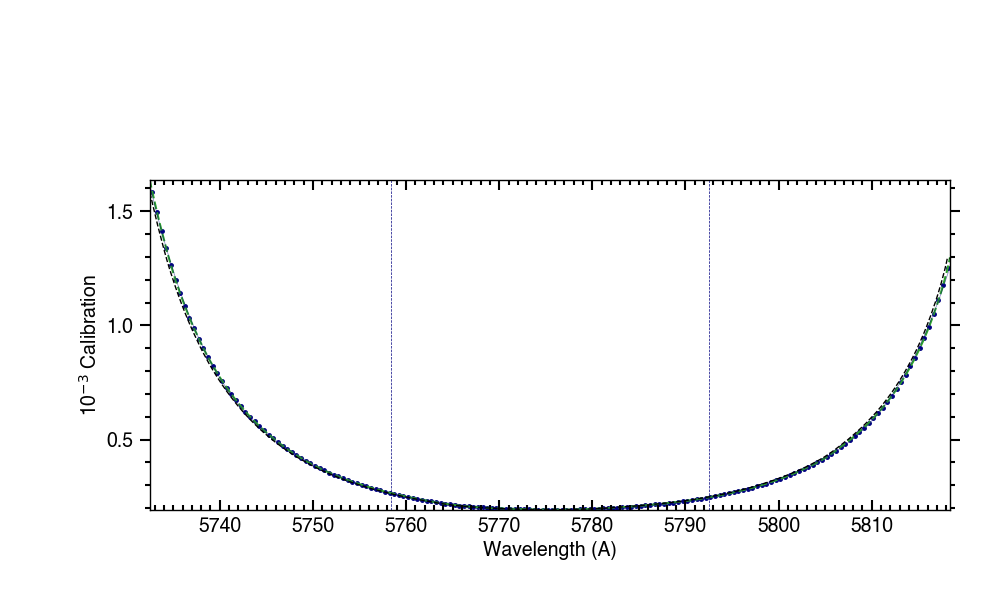

In [20]:
if 'spec' in input_nbook['par']['type']:display(Image(filename = input_nbook['plot_path']+'General/gcal/'+input_nbook['par']['instrument']+'/'+input_nbook['par']['night']+'/'+'gcal_ord'+str(input_nbook['sp_reduc']['iord2plot_gcal'])+'.png'))

This plot displays the noise contributions (variance, in flux units) from photons and from the detector in your chosen exposure and spectral order

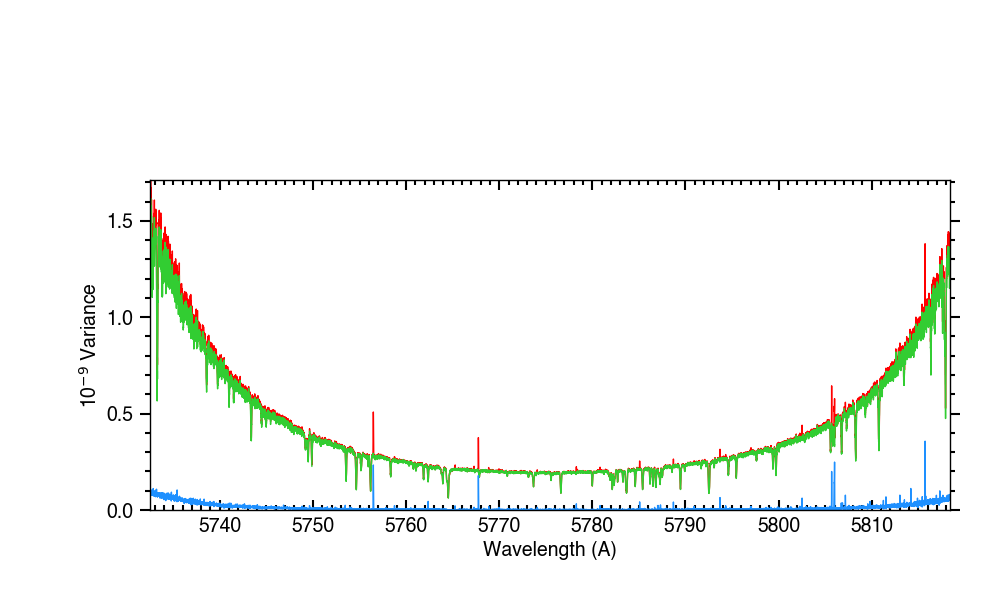

In [21]:
path = ANTARESS_nbook_bground.find_plot(input_nbook['plot_path']+'General/gcal/'+input_nbook['par']['instrument']+'/'+input_nbook['par']['night']+'/'+'noises_ord'+str(input_nbook['sp_reduc']['iord2plot_gcal'])+'.png')
if path is not None:display(Image(filename = path))

**Telluric CCF**

This plot displays the telluric CCFs computed with the measured spectrum (red), the model telluric spectrum (green), and the telluric-corrected measured spectrum (blue).
Dashed profiles correspond to the list of strong lines used to perform the fits, and solid profiles to the full list of telluric lines used for the correction.

Choose the telluric species (among those for which you ran the correction !) and exposure to plot.

In [22]:
tell_sp2plot = 'H2O' 
iexp2plot = 5

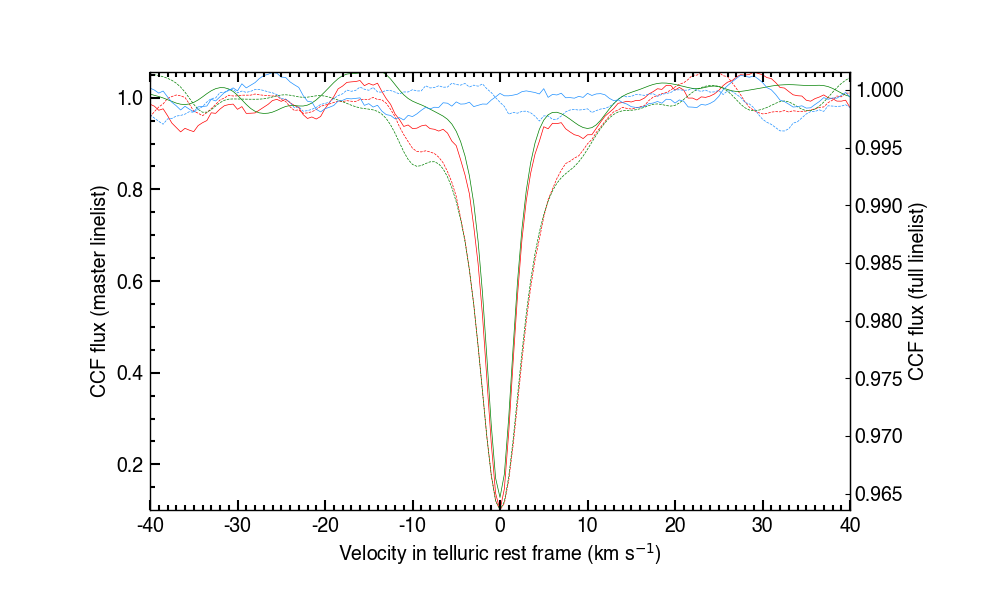

In [23]:
if 'spec' in input_nbook['par']['type']:display(Image(filename = input_nbook['plot_path']+'Spec_raw/Tell_corr/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/'+'Tell_CCF'+'/'+tell_sp2plot+'_idx'+str(iexp2plot)+'.png'))

**Telluric properties**

This plot displays the properties of the best-fit atmospheric model used to compute the telluric spectrum, as a function of orbital phase.

Choose the telluric species and property to plot, among:
- `Temperature`  (in K) : temperature of the Earth model layer
- `Pressure_LOS` (in atm) : average pressure over the layers occupied by the species
- `ISV_LOS` (in cm-2) : integrated species vapour along the LOS

In [24]:
tell_sp2plot = 'H2O' 
prop2plot = 'Pressure_LOS'

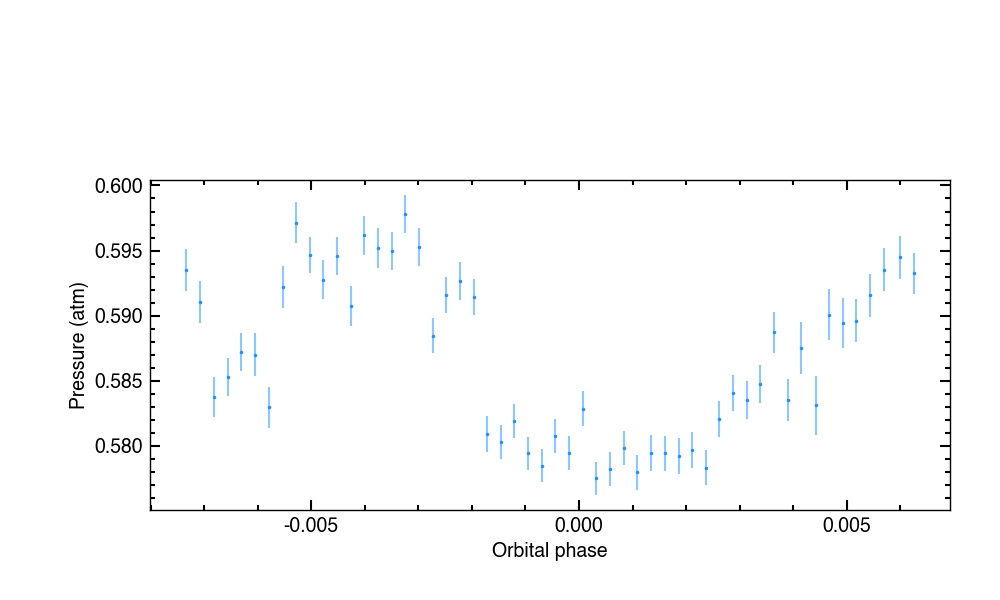

In [25]:
if 'spec' in input_nbook['par']['type']:display(Image(filename = input_nbook['plot_path']+'Spec_raw/Tell_corr/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/Tell_prop/'+tell_sp2plot+'_'+prop2plot+'.png'))

**Flux balance**

This plot displays the flux balance variation between each exposure spectrum and the reference spectrum over the visit (colored disks, from purple to red with increasing time). 
Solid lines with matching color are the corresponding best-fit spline models. 

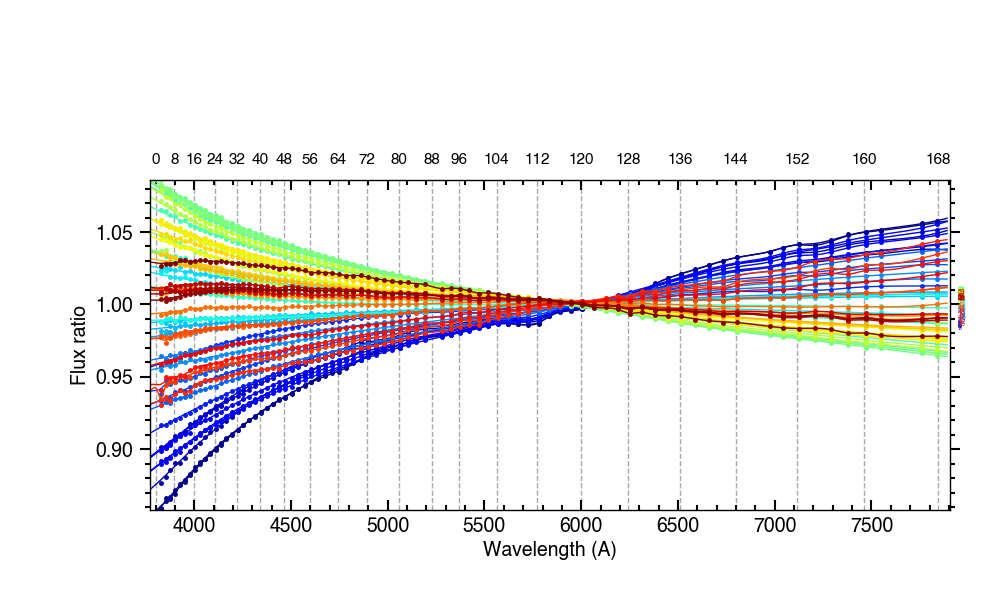

In [26]:
if 'spec' in input_nbook['par']['type']:display(Image(filename = input_nbook['plot_path']+'Spec_raw/FluxBalance/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_global.png'))

**Cosmic rays detection**

This plot displays the flux deviation between the spectrum of an exposure and the mean of adjacent exposures, divided by the error on the exposure spectrum (green) and by the standard deviation over the adjacent exposures (black).

Choose the indexes of the exposure and order to be plotted. Only exposure and orders with flagged cosmics have been saved to plots.

In [27]:
iexp2plot = 0
iord2plot = 102

Exposure and order have detected cosmics


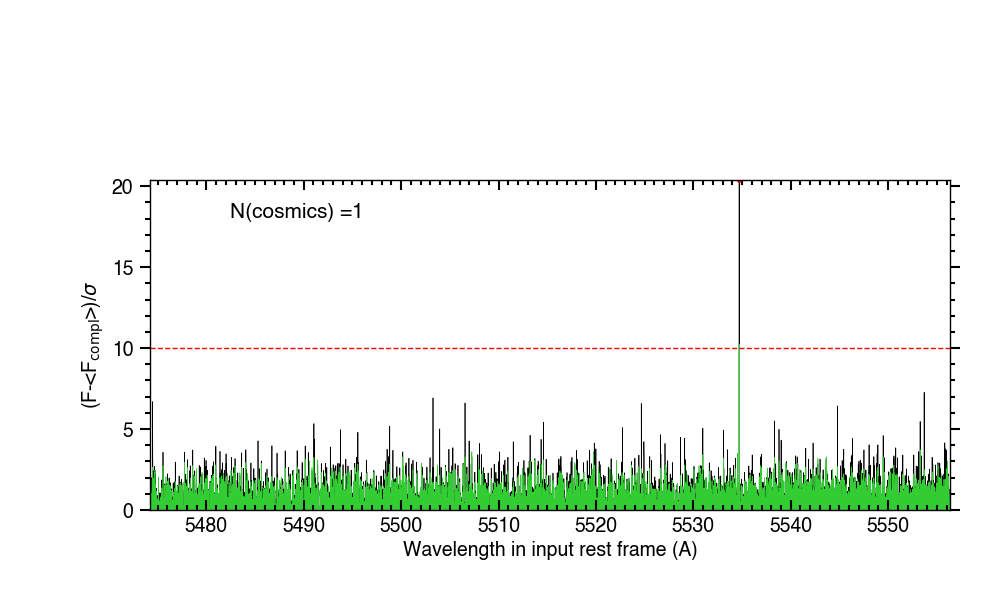

In [28]:
if 'spec' in input_nbook['par']['type']:
    cosm_found = ANTARESS_nbook_bground.cosmic_search(iexp2plot, iord2plot, input_nbook)
    if cosm_found:display(Image(data=input_nbook['plot_path']+'Spec_raw/Cosmics/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/'+'idx'+str(iexp2plot)+'_iord'+str(iord2plot)+'.png'))

**Cosmic rays distribution**

This plot displays the cosmic occurences over the full spectrum, in each exposure (colored from purple to red with increasing time) and cumulated over all exposures (in black, scaled to the axis range). 
If many more cosmics are flagged in the blue part of the spectrum, your detection threshold may be too low and noisy pixels are flagged.

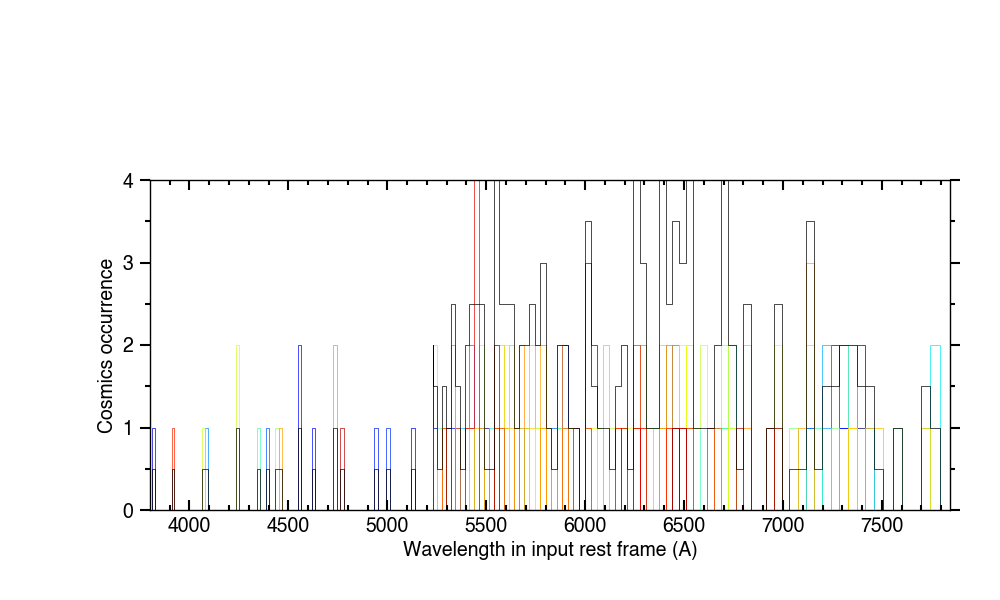

In [29]:
if 'spec' in input_nbook['par']['type']:display(Image(filename = input_nbook['plot_path']+'Spec_raw/Cosmics/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/'+'Occurrences.png'))

**Wiggles**

The first plot displays an exposure transmission spectrum, masked for your chosen screened regions. Each spectral order is plotted with a differet color. The black spectrum is binned to better visualize the wiggles.

The second plot displays the same spectrum, before correction (top) with the best-fit filter model overplotted, and after correction (bottom). The pre-correction periodogram (right) typically shows two sharp peaks corresponding to the main wiggle components.

The third plot displays the root mean square (RMS) of the transmission spectra in each exposure, and their ratio with the spectrum mean error.

Choose the index of the exposure you want to plot.

In [30]:
iexp2plot = 5

In [31]:
path = ANTARESS_nbook_bground.find_plot(input_nbook['plot_path']+'Spec_raw/Wiggles/Exp_fit/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/Init/ExpGroup'+str(iexp2plot)+'.png')
if path is not None:display(Image(filename = path))

Plot does not exist


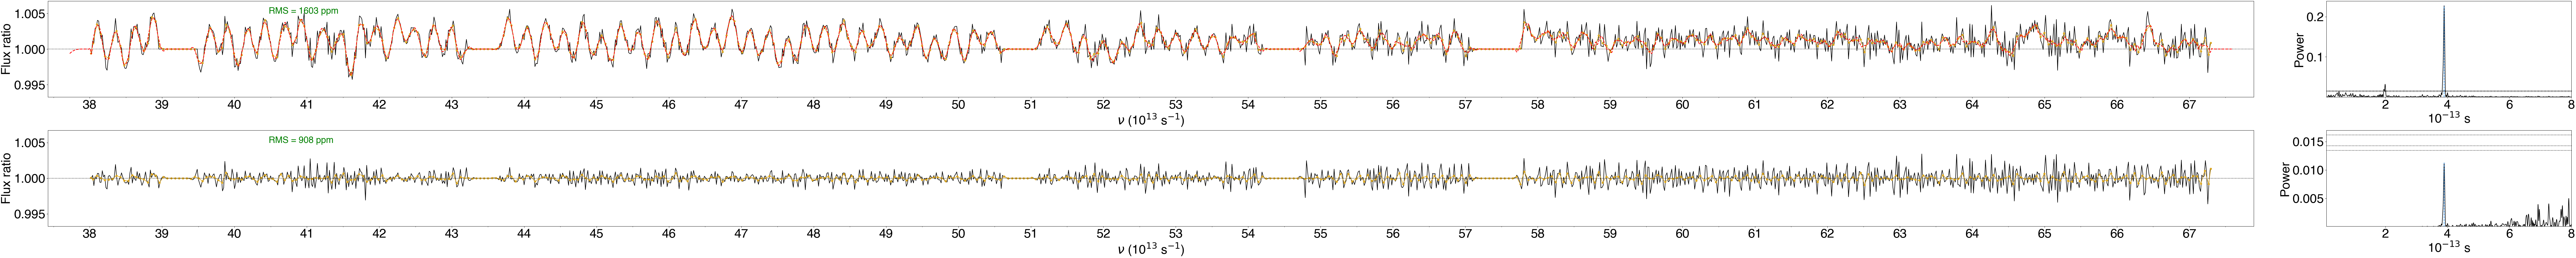

In [32]:
path = ANTARESS_nbook_bground.find_group(iexp2plot,input_nbook['plot_path']+'Spec_raw/Wiggles/Exp_fit/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/Filter/')
if path is not None:display(Image(filename = path))


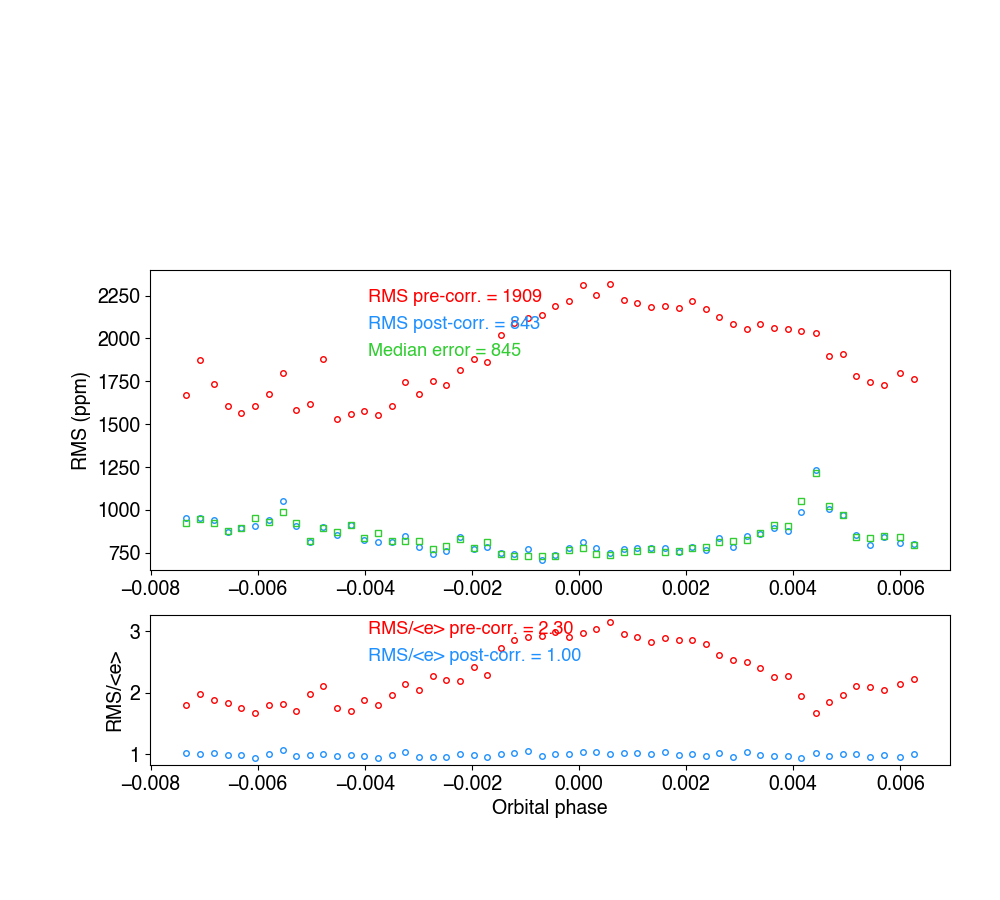

In [33]:
path = ANTARESS_nbook_bground.find_plot(input_nbook['plot_path']+'Spec_raw/Wiggles/Exp_fit/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'/Filter/RMS_all.png')
if path is not None:display(Image(filename = path))

**Stellar CCF**

This plot displays the CCFs computed from disk-integrated stellar spectra.

Choose the index of the exposure you want to plot

In [ ]:
iexp2plot = 5

In [ ]:
path = ANTARESS_nbook_bground.find_exp(iexp2plot, input_nbook['plot_path']+'DI_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/'+input_nbook['par']['type']+'/')
if path is not None:display(Image(filename = path))